<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Background-info..." data-toc-modified-id="Background-info...-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Background info...</a></span></li><li><span><a href="#Let's-process-a-sample-session" data-toc-modified-id="Let's-process-a-sample-session-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Let's process a sample session</a></span><ul class="toc-item"><li><span><a href="#Extract-useful-task-event-timestamps" data-toc-modified-id="Extract-useful-task-event-timestamps-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Extract useful task event timestamps</a></span></li><li><span><a href="#Convert-neural-spike-times-to-useful-spike-trains-and-firing-rates" data-toc-modified-id="Convert-neural-spike-times-to-useful-spike-trains-and-firing-rates-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Convert neural spike times to useful spike trains and firing rates</a></span></li><li><span><a href="#Bandpass-and-chop-LFP" data-toc-modified-id="Bandpass-and-chop-LFP-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Bandpass and chop LFP</a></span></li></ul></li></ul></div>

# Background info...

This is the task:

<img src="data_clean/task_illustration.png" style="height:200px;">

Psychometric curves:

<img src="data_clean/psychometric_curves.png" style="height:200px;">



# Let's process a sample session

In [1]:
from os.path import join as pjoin
import glob
import matplotlib.pyplot as plt
import numpy as np

import ephyspipe.brain as brain
import ephyspipe.behavior as bhv

# paths for this data...
data_dir = "data_clean"
out_dir = "output"
session = "George00_rec14_01282021"

bhv_fnames = sorted(glob.glob(pjoin(data_dir, session + "*bhv*")))
spk_fname = glob.glob(pjoin(data_dir, session + "*units*"))[0]
lfp_fname = glob.glob(pjoin(data_dir, session + "*LFP*"))[0]

For this demo, I'll limit the analyses to a few channels with some fun neurons:

In [2]:
fun_channels = [107, 110, 112]

## Extract useful task event timestamps

Load the raw behavior files, plus the duplicate event codes sent to the neural data files.

(These files load slowly because they are organized in a complicted/ugly matlab struct. In the future, it would be useful to reformat into something simpler while converting from \*.bhv2 to \*.mat.)

In [3]:
# load all of the trial information 
bhv_data = bhv.load_raw_bhv(bhv_fnames)

# load duplicate event codes from the neural data
pl2_codes = bhv.load_pl2_codes(spk_fname)  # can also use lfp_fname

data_clean/George00_rec14_01282021-bhv_A.mat
data_clean/George00_rec14_01282021-bhv_B.mat
data_clean/George00_rec14_01282021-bhv_C.mat


Extract the timestamp of interesting events, e.g. picture onset (code = 20), selecting the left(23) or right (24) option, etc. 

(Aside from trial start (9) and stop (18) codes, these are unique for each experiment. All we need for the next step is a vector of timestamps, so it should be very flexible for future custom functions.)

In [4]:
# get timestamps for picture onset
code_pictures = 20
sync_pictures_ts = bhv.get_trial_events(bhv_data, 
                                        pl2_codes, 
                                        code_pictures)

Let's make sure these time points make sense. These picture onset timestamps are a proxy for trials over the session.

Trials take \~5 seconds and should span the entire 2 hour session (\~7,200 seconds). In this session, the animal started to loose motivation in the second hour so we should see a drop in the number of trials.

(0.0, 8000.0)

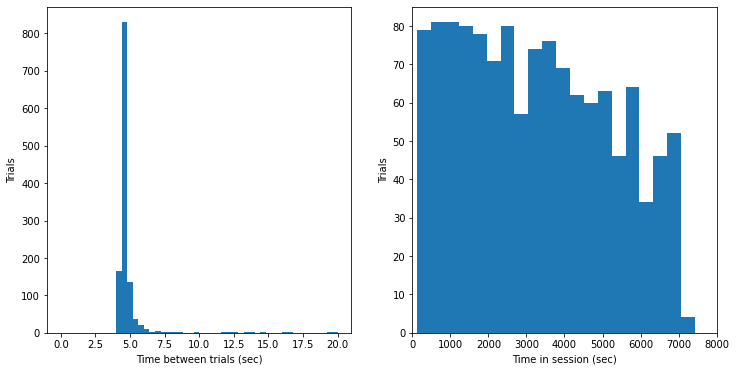

In [5]:
# drop trials that weren't initiated:
keep_trials = sync_pictures_ts > 0

fig = plt.figure(figsize=(12, 6))

# inter trial interval
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(np.diff(sync_pictures_ts[keep_trials]), bins=50, range=(0, 20))
ax1.set_xlabel("Time between trials (sec)")
ax1.set_ylabel("Trials")

# trial onset distributions
ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(sync_pictures_ts[keep_trials], 20)
ax2.set_xlabel("Time in session (sec)")
ax2.set_ylabel("Trials")
ax2.set_xlim((0, 8000))

While we're looking at the behavior, let's pull out some useful taks information that we can use to analyze our neural data later.

In [6]:
# to do

## Convert neural spike times to useful spike trains and firing rates

For each neuron, we start with spike times (i.e. voltage crossed a 4 st. dev. threshold) over the entire 2 hours session with 40 kHz resolution. We want to convert those to a spike train (0 or 1 to indicate a spike) and smoothed firing rates (50ms boxcar) at 1kHz sampling frequency.

(Note: neurons and units are the same thing. I was inconsistent when writing this code. Sorry for the jargon!)

In [7]:
%%time
spk_train, spk_fr, spk_meta = brain.process_raw_spk(spk_fname, fun_channels)

CPU times: user 1.66 s, sys: 314 ms, total: 1.97 s
Wall time: 2.03 s


These are the neurons we pulled from these channels:

In [8]:
spk_meta

,ID,channel,mean_fr
0,SPK_SPKC107a,107,10.822193
1,SPK_SPKC107b,107,10.028342
2,SPK_SPKC110a,110,1.783157
3,SPK_SPKC112a,112,1.956659
4,SPK_SPKC110aa,110,1.863296
5,SPK_SPKC112aa,112,2.018020


Right now, each neuron corresponds to one row in this giant array (2 hr session, 1 kHz sampling):

In [9]:
print(spk_train.shape)

(6, 7561868)


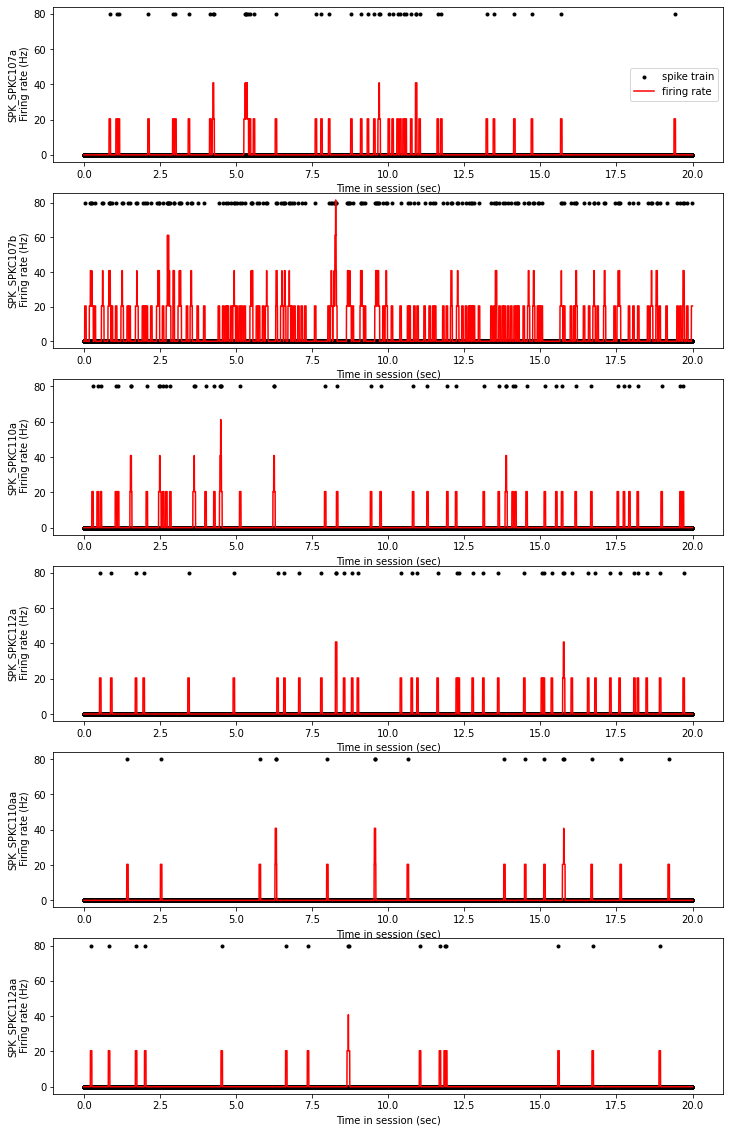

In [10]:
# make sure spike trains and smoothed firing rates are aligned 
# and sensible

nunits = spk_meta.shape[0]  # number of neurons we want to display
ts = np.arange(0, 20, 0.001)  # let's just look at the first 10 seconds 
ntimes = ts.shape[0]

fig = plt.figure(figsize=(12, 20))

for u in range(nunits):
    ax = fig.add_subplot(nunits, 1, u + 1)
    ax.scatter(ts, 80 * spk_train[u, :ntimes], 
               c="k", marker=".")  # scale for vis
    ax.plot(ts, 1000 * spk_fr[u, :ntimes], "r")  # scale to sec 
    
    ax.set_xlabel("Time in session (sec)")
    ax.set_ylabel(spk_meta.ID[u] + "\n Firing rate (Hz)")
    
    if u == 0:
        ax.legend(["spike train", "firing rate"])

Let's chop up this array by the event codes we pulled from the behavior it's in a useful shape for analysis:

`output : 3D np array
    event_sync_points x time_around_event x neurons`
    
(Note: A typical session has >1000 trials and >100 neurons and LFP channels, so for loops can get quite slow! Converting this to matrix indexing changed my life :) Check out `brain.chop()` for details.)

(Note 2: In the future, it would be cool to throw all of this neural data into an xarray! Sticking with numpy arrays for now to make the code more accessible...)

In [11]:
%%time
time_window = (-1, 1)  # in sec, time around each event
ts_chopped = np.arange(time_window[0], 
                       time_window[1], 0.001)  # new time axis

spk_train_chopped = brain.chop(spk_train, sync_pictures_ts, time_window)
spk_fr_chopped = brain.chop(spk_fr, sync_pictures_ts, time_window)

print(spk_fr_chopped.shape)

(1417, 2000, 6)
CPU times: user 396 ms, sys: 148 ms, total: 544 ms
Wall time: 621 ms


In [12]:
# this is a good intermediate point to save
train_fname = pjoin(out_dir, session + "_spk_train_chopped.npz")
np.savez(train_fname, ts_chopped=ts_chopped, 
         spk_train_chopped=spk_train_chopped, 
         spk_meta=spk_meta)

fr_fname = pjoin(out_dir, session + "_spk_fr_chopped.npz")
np.savez(fr_fname, ts_chopped=ts_chopped, 
         spk_fr_chopped=spk_fr_chopped, 
         spk_meta=spk_meta)

Depending on the analysis, we might want to downsample the signal or further restrict the time window we're interested in:

In [13]:
%%time
# smooth firing rates in 100 ms windows overlapping by 75% (default), 
# limited to (-0.5, 0.75) sec around the event

time_window_mini = (-0.5, 0.75)  # in sec
window = 0.1 # in sec

ts_100ms, spk_fr_100ms = brain.sliding_avg(spk_fr_chopped, 
                                           ts_chopped, 
                                           time_window_mini,
                                           window)

CPU times: user 246 ms, sys: 10.2 ms, total: 256 ms
Wall time: 327 ms


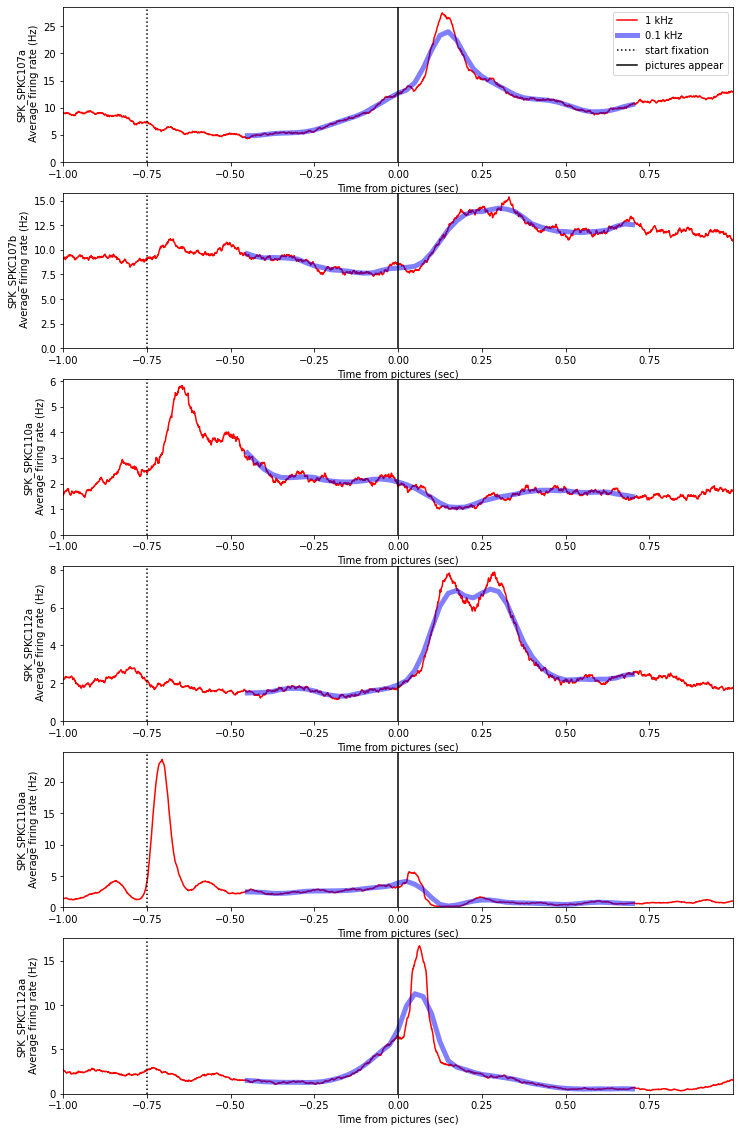

In [14]:
# show the average firing rate across all initiated trials

fig = plt.figure(figsize=(12, 20))
for u in range(nunits):
    ax = fig.add_subplot(nunits, 1, u + 1)
    ax.plot(ts_chopped, 
            np.mean(1000 * spk_fr_chopped[keep_trials, :, u], axis=0), 
            c="r")
    ax.plot(ts_100ms, 
            np.mean(1000 * spk_fr_100ms[keep_trials, :, u], axis=0),
            c="b", linewidth=5, alpha=0.5)
    
    Y = ax.get_ylim()
    new_Y = (0, Y[1])
    ax.plot(np.array([-.75, -.75]), new_Y, c="k", linestyle=":")
    ax.plot(np.array([0, 0]), new_Y, c="k")
    ax.set_ylim(new_Y)
    ax.set_xlim(ts_chopped[[0, -1]])
    
    if u == 0:
        ax.legend(["1 kHz", "0.1 kHz", "start fixation", 
                   "pictures appear"])
        
    ax.set_xlabel("Time from pictures (sec)")
    ax.set_ylabel(spk_meta.ID[u] + "\n Average firing rate (Hz)")

## Bandpass and chop LFP 